In [191]:
import re
import pandas as pd
import numpy as np
from pathlib import Path
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import *
import matplotlib.font_manager

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

# params
pd.set_option("max_colwidth", 0)
sns.set_context("talk")
sns.set_palette(sns.color_palette("colorblind", 10))

matplotlib.rc("font", family="Arial Unicode MS")

%matplotlib inline

### Reading Data ###

In [192]:
# import dataset

train_data = pd.read_csv('newsHeadlineDataset.csv')
df = pd.DataFrame(train_data)
df

,category,texts
0,ham,สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย
1,ham,สธ.เพิ่มศักยภาพโรงพยาบาลธัญญารักษ์ภูมิภาครองรับผู้ป่วยจิตเวชทั่วประเทศ
2,spam,หุ้นเทรดยักษ์ใหญ่กำไรแน่นเริ่มต้นเทรดเพียง 1000 บาทรับปันผล 30000 ต่อเดือน
3,spam,"กรมการจัดหางาน เปิดโครงการ ""ไม่เลือกงาน ไม่ยากจน"" ให้คนไทยมีรายได้เสริม"
4,spam,"เพจ SAO Trading ในเครือของ AOT เปิดให้ลงทุนเริ่มต้น 1,000 บาท"
...,...,...
2635,spam,ร่วมลงทุนกับGULFเริ่มต้นที่30หน่วยปันผลกำไรต่อวัน7%-12%
2636,ham,สำนักงานสลากฯเปิดตัวแผงสลากดิจิทัลผ่านเว็บไซต์www.glolotteryshop.com
2637,spam,เติมน้ำมันพืชแทนน้ำมันดีเซล ช่วยให้รถยนต์ประหยัดน้ำมันมากขึ้น
2638,ham,รับประทานผลไม้สดหรืออบแห้งผักสดถั่วต่างๆเหมาะกับผู้เป็นอาการวัยทอง


In [193]:
df.describe()

,category,texts
count,2640,2640
unique,2,2640
top,ham,สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย
freq,1320,1


In [194]:
df[df.duplicated()]

,category,texts


In [195]:
df.groupby("category").describe()

texts         \
         count unique   
category                
ham       1320  1320    
spam      1320  1320    

                                                                                      \
                                                                                 top   
category                                                                               
ham       สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย                       
spam      หุ้นเทรดยักษ์ใหญ่กำไรแน่นเริ่มต้นเทรดเพียง 1000 บาทรับปันผล 30000 ต่อเดือน   

               
         freq  
category       
ham       1    
spam      1

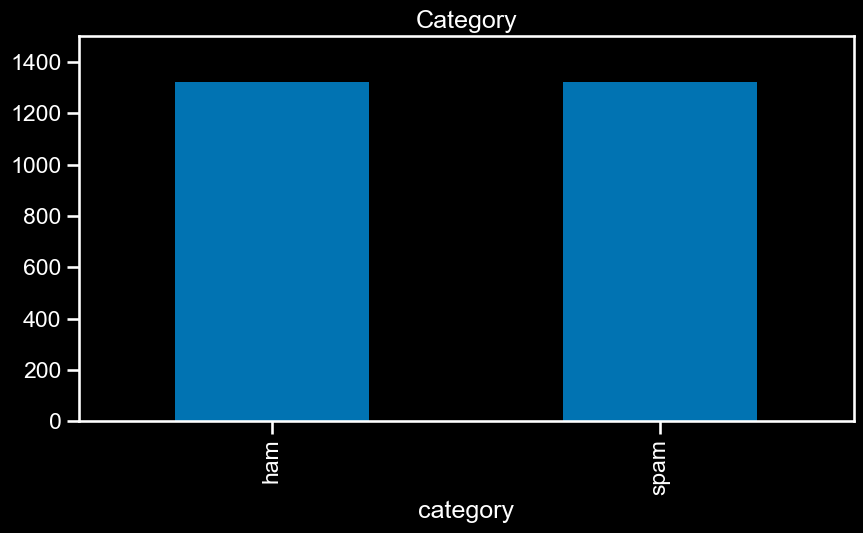

In [196]:
row_count_by_category = df.category.value_counts()
ax = row_count_by_category.plot(kind='bar', title="Category", figsize=(10, 5))
ax.set_ylim(0, 1500)
for i, label in enumerate(row_count_by_category):
    ax.annotate(str(label), (i-0.1, label + 500))

### TF-IDF visualization ###

In [197]:
def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''

    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ["feature", "score"]

    return df

In [198]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''

    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)

    return top_feats(tfidf_means, features, top_n)

In [199]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''

    dfs = []
    labels = np.unique(y)

    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)

    return dfs

In [200]:
def plot_classfeats_h(dfs, score_name=''):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''

    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))

    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel(f"Mean {score_name} Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        ax.invert_yaxis()
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)

    plt.show()

In [201]:
def show_classfeats(df, vectorizer, analyzer, score_name='', text_col='texts', class_col='category', is_emoji=False):
    vec = vectorizer(analyzer=analyzer)
    mat = vec.fit_transform(df[text_col])
    dfs = top_feats_by_class(mat, df[class_col], vec.get_feature_names_out())

    if is_emoji:
        for dataframe in dfs:
            dataframe.columns = [dataframe.label, 'tfidf_' + dataframe.label]
        return pd.concat(dfs, axis=1)
    else:
        plot_classfeats_h(dfs, score_name=score_name)

In [202]:
import string
import emoji
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = "".join(nopunc)
    
    return [word for word in word_tokenize(nopunc) if word and not re.search(pattern=r"\s+", string=word)]

def extract_url(text):
    URL_PATTERN = r"(https?:\/\/)?\.([\da-z-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S"
    return [url[1] for url in re.findall(pattern=URL_PATTERN, string=text.lower())]

def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

def extract_punc(text):
    return [char for char in text if char in string.punctuation]

def extract_hashtags(text):
    HASHTAG_PATTERN = r"#[a-zA-Z0-9ก-๙]+"
    return re.findall(pattern=HASHTAG_PATTERN, string=text)

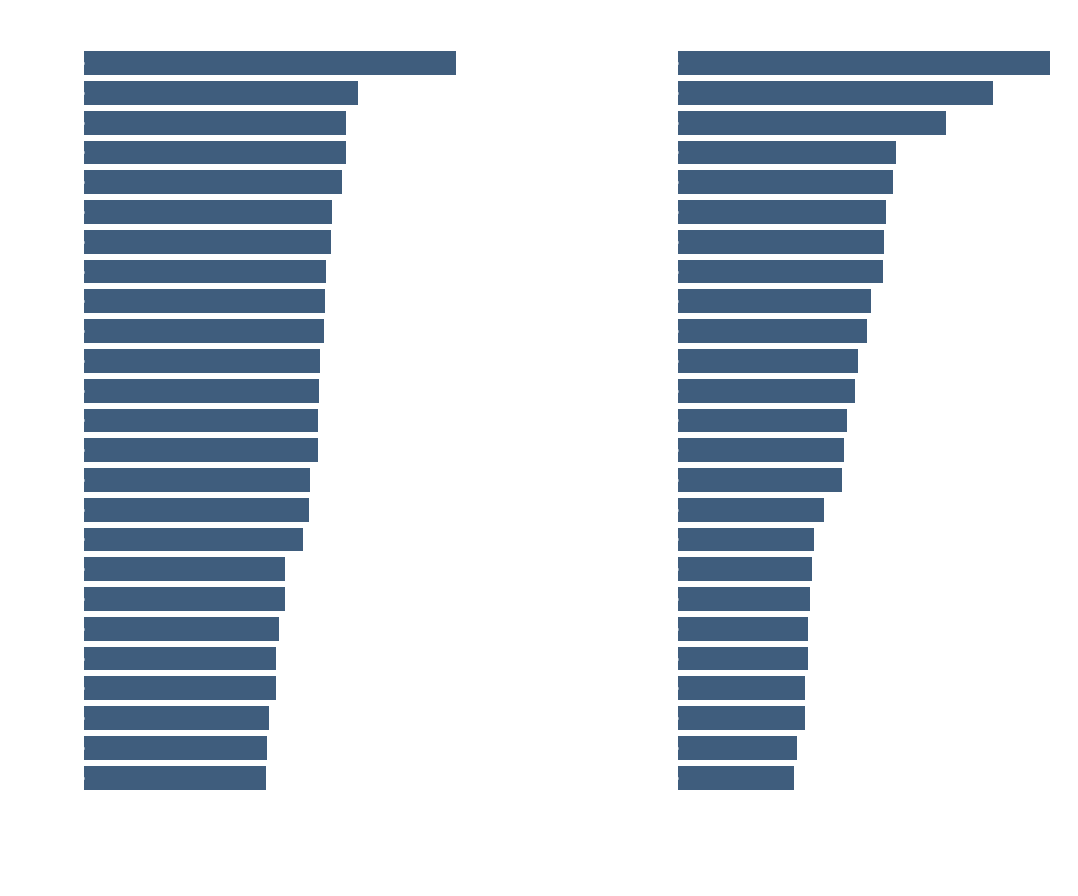

In [203]:
show_classfeats(
    df=df[:2640],
    vectorizer=TfidfVectorizer,
    analyzer=process_text,
    score_name="tf-idf",
)

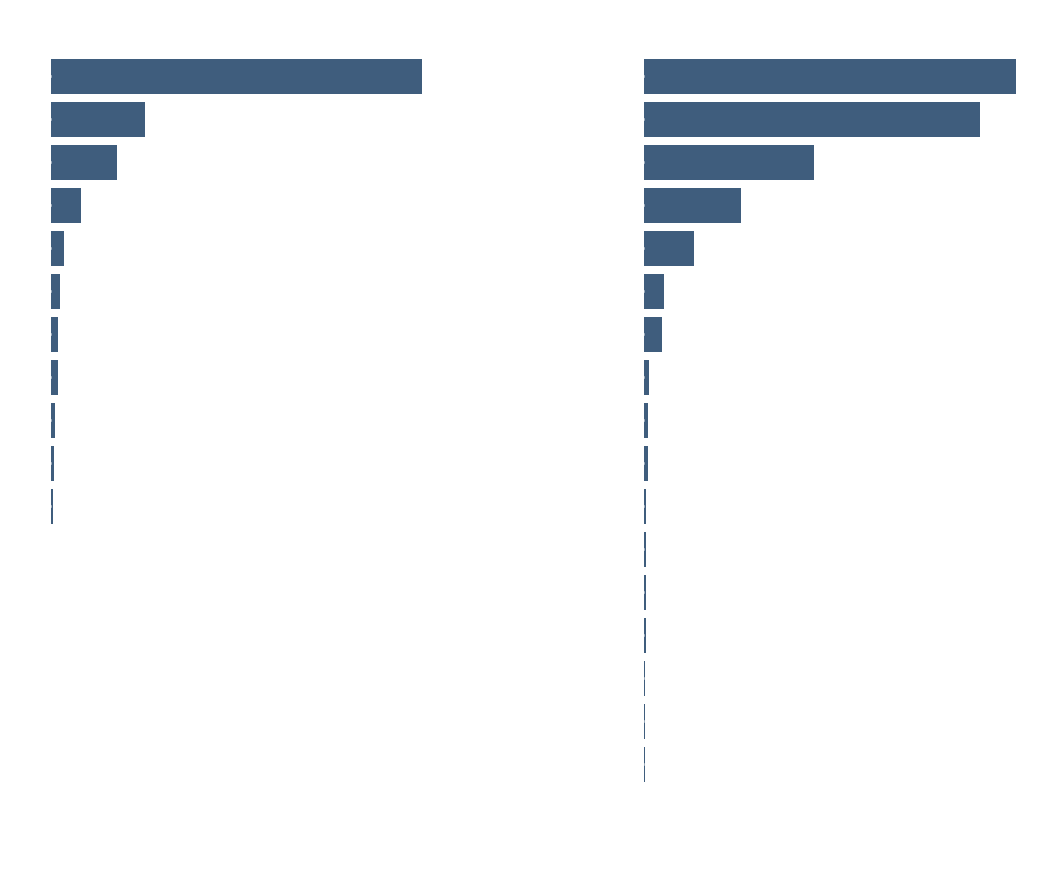

In [204]:
# Punctuation

show_classfeats(df=df, vectorizer=TfidfVectorizer, score_name="tf-idf", analyzer=extract_punc)

In [205]:
# Create new dataframe

sentiment_df = df
sentiment_df

,category,texts
0,ham,สธ. เปิดตัวรถฟอกไตเคลื่อนที่นวัตกรรมต้นแบบคันแรกของไทย
1,ham,สธ.เพิ่มศักยภาพโรงพยาบาลธัญญารักษ์ภูมิภาครองรับผู้ป่วยจิตเวชทั่วประเทศ
2,spam,หุ้นเทรดยักษ์ใหญ่กำไรแน่นเริ่มต้นเทรดเพียง 1000 บาทรับปันผล 30000 ต่อเดือน
3,spam,"กรมการจัดหางาน เปิดโครงการ ""ไม่เลือกงาน ไม่ยากจน"" ให้คนไทยมีรายได้เสริม"
4,spam,"เพจ SAO Trading ในเครือของ AOT เปิดให้ลงทุนเริ่มต้น 1,000 บาท"
...,...,...
2635,spam,ร่วมลงทุนกับGULFเริ่มต้นที่30หน่วยปันผลกำไรต่อวัน7%-12%
2636,ham,สำนักงานสลากฯเปิดตัวแผงสลากดิจิทัลผ่านเว็บไซต์www.glolotteryshop.com
2637,spam,เติมน้ำมันพืชแทนน้ำมันดีเซล ช่วยให้รถยนต์ประหยัดน้ำมันมากขึ้น
2638,ham,รับประทานผลไม้สดหรืออบแห้งผักสดถั่วต่างๆเหมาะกับผู้เป็นอาการวัยทอง


### Tokenize text ###

In [206]:
def preprocess_thai_text(texts):
    # Tokenization
    tokens = word_tokenize(texts)
    
    # Stopword removal
    filtered_tokens = [word for word in tokens if word not in thai_stopwords()]
    
    # Join the tokens back into a clean text
    clean_text = " ".join(filtered_tokens)
    
    return clean_text

punc = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''

def remove_punc(text):
    clean_text = text.lower()
    
    for text in punc:
        if text in string.punctuation:
            clean_text = clean_text.replace(text, "")
    return clean_text

def remove_whitespace(text):
    cleaned_text = ' '.join(text.split())
    return cleaned_text.lower()

def remove_numbers(text):
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text


sentiment_df['texts'] = sentiment_df.texts.map(lambda x: " ".join(word_tokenize(x)))
sentiment_df['texts'] = sentiment_df['texts'].apply(remove_punc)
sentiment_df['texts'] = sentiment_df['texts'].apply(remove_numbers)
sentiment_df['texts'] = sentiment_df['texts'].apply(remove_whitespace)
sentiment_df['texts']

0       สธ . เปิดตัว รถ ฟอก ไต เคลื่อนที่ นวัตกรรม ต้นแบบ คัน แรก ของ ไทย                 
1       สธ . เพิ่ม ศักยภาพ โรงพยาบาล ธัญ ญา รักษ์ ภูมิภาค รองรับ ผู้ป่วย จิตเวช ทั่วประเทศ
2       หุ้น เทรด ยักษ์ ใหญ่ กำไร แน่น เริ่มต้น เทรด เพียง บาท รับ ปันผล ต่อ เดือน        
3       กรมการจัดหางาน เปิด โครงการ ไม่ เลือก งาน ไม่ ยากจน ให้ คนไทย มี รายได้ เสริม     
4       เพจ sao trading ในเครือ ของ aot เปิด ให้ ลงทุน เริ่มต้น บาท                       
                                   ...                                                    
2635    ร่วม ลงทุน กับ gulf เริ่มต้น ที่ หน่วย ปัน ผลกำไร ต่อ วัน                         
2636    สำนักงาน สลาก ฯ เปิดตัว แผง สลาก ดิจิทัล ผ่าน เว็บไซต์ www .glolotteryshop.com    
2637    เติม น้ำมันพืช แทน น้ำมันดีเซล ช่วย ให้ รถยนต์ ประหยัด น้ำมัน มากขึ้น             
2638    รับประทาน ผลไม้ สด หรือ อบ แห้ง ผักสด ถั่ว ต่างๆ เหมาะกับ ผู้ เป็น อาการ วัยทอง   
2639    การประปาส่วนภูมิภาค แจ้ง นโยบาย ช่วย ภัยแล้ง ชดเชย หลังคาเรือน ละ บาท ต่อ เดือน   

### Train-Test Split ###

In [207]:
from sklearn.model_selection import train_test_split

class_names = np.unique(sentiment_df.category).tolist()

X = sentiment_df["texts"]
y = sentiment_df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [208]:
X_test

2417    ออมสิน ปล่อย สินเชื่อ ห่วงใย ผ่าน เพจ สาขา มณี mymo วงเงิน บาท                            
2566    ครม. อนุมัติ ค่ารักษาพยาบาล จาก เดิม เพิ่ม เป็น บาท                                       
2325    ตลาดหลักทรัพย์ ฯ เปิดโอกาส ให้ ร่วม ลงทุน กับ cpall ลงุทน รับ ปันผล บาท ต่อ วัน           
626     กอง สลาก ฯ ให้ เลข ออกรางวัล ล่วงหน้า กับ คน ที่ทำงาน ใน กอง สลาก ฯ                       
2174    ตรวจ พบ ยา ชนิด ใหม่ “ ฟลูอัลป รา โซ แล ม ” ใน erimin                                     
                                ...                                                               
1119    ชลประทาน ระบาย น้ำลด ระดับ เก็บ กัก ช่วย ปชช . ใน พื้นที่ อ่าง ฯ โปร่ง ขุน เพชร จ. ชัยภูมิ
722     กรม อุตุฯ ร่วมกับ ผู้ให้บริการ โทรศัพท์เคลื่อนที่ ส่ง ข้อความ แจ้ง เตือน ภัยธรรมชาติ      
1690    พ่อ แม่ ลูก กรุ๊ป เลือด ไม่ เหมือนกัน ใช่ ครอบครัว เดียวกัน                               
2574    สิทธิบัตร ทอง ช่วยเหลือ กรณี สูงสุด แสน บาท                                               
1974    กร

In [209]:
y_test

2417    spam
2566    ham 
2325    spam
626     spam
2174    ham 
       ...  
1119    ham 
722     ham 
1690    ham 
2574    ham 
1974    spam
Name: category, Length: 528, dtype: object

### *Multinomial Naive Bayes* ###

In [210]:
from typing import Any
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB

def dummy(obj: Any) -> Any:
    return obj

NB_clf = make_pipeline(
    CountVectorizer(preprocessor=dummy, tokenizer=dummy, lowercase=False, ngram_range = (1, 2)),
    TfidfTransformer(norm='l2'),
    StandardScaler(with_mean=False),
    MaxAbsScaler(),
    MultinomialNB(alpha=1e-01, class_prior = [.2, .8])
)

%time NB_clf.fit(X_train, y_train)

NB_clf.predict(X_test)
score = NB_clf.score(X_test, y_test)

print("Accuracy: ", score)

CPU times: user 145 ms, sys: 2.57 ms, total: 147 ms
Wall time: 147 ms
Accuracy:  0.8200757575757576


In [211]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score

print()
print("Training:\n")

ypred_test = NB_clf.predict(X_test)
mat_clf = confusion_matrix(y_test, ypred_test)
report_clf = metrics.classification_report(y_test, ypred_test)

# Confusion matrix
clf_matrix = metrics.confusion_matrix(y_test, ypred_test)

print(mat_clf)
print(report_clf)

y_pred_proba = NB_clf.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print("AUC score: ", auc)


Training:

[[222  42]
 [ 53 211]]
              precision    recall  f1-score   support

         ham       0.81      0.84      0.82       264
        spam       0.83      0.80      0.82       264

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.82      0.82      0.82       528

AUC score:  0.896392906336088


In [212]:
y_test_rep = y_test
ypred_test_rep = ypred_test

mapping = {"ham": 0, "spam": 1}
y_test_rep = [mapping[label] for label in y_test]
ypred_test_rep = [mapping[label] for label in ypred_test]

In [213]:
from sklearn.metrics import f1_score

print("F1-score: ", f1_score(y_test_rep, ypred_test_rep))

F1-score:  0.816247582205029


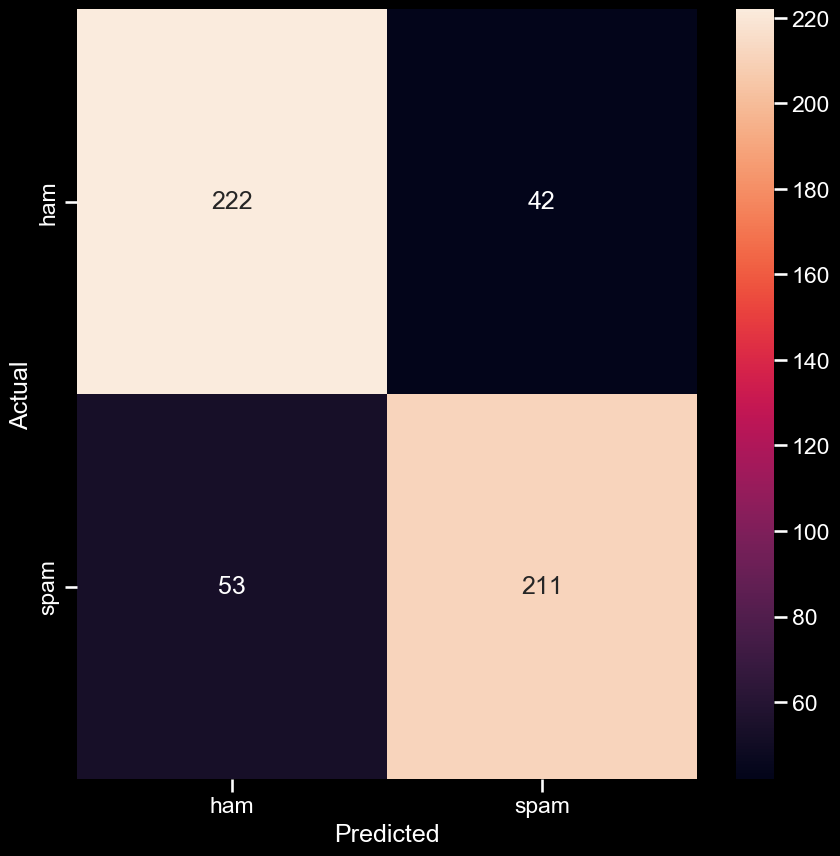

In [214]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, NB_clf.predict(X_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [215]:
from collections import Counter

predict_msg = ["รองต่อ รุดที่เกิดเหตุหลัง ผกก.ทล. เครียดกรณี สว.แบงค์ ก่อนยิงตัวตาย",
               "วงจรปิดชัด หน่อง ท่าผา ขับรถมาคันเดียว เลี้ยวเข้าซอยก่อนโดนวิสามัญ",
               "ผกก.สน.พญาไท โดนหางเลข ร่วมงานเลี้ยงบ้าน กำนันนก น.1 สั่งตั้ง กก.สอบ",
               "อนุทิน ชมฝ่ายค้านมีสปิริตอภิปราย ไม่ไล่บี้รัฐบาล ยังอุบชื่อรองโฆษกฯ",
               "นายกฯ เตือน โตๆ กันแล้ว จ่อคุยเยอรมนี ปมเครื่องยนต์เรือดำน้ำ “โรม” ประท้วงเสียดสี",
               "ตลาดหลักทรัพย์ฯร่วมกับบริษัทมหาชนที่ดำเนินธุรกิจด้านการลงทุนและพัฒนาอสังหาริมทรัพย์เปิดให้ซื้อกองทุนวัยเกษียณ10,000บาทปันผล10-12%",
               "ลงทุนในสินทรัพย์Top10ของโลกเริ่มต้น1,000บาทภายใต้การควบคุมของตลาดหลักทรัพย์แห่งประเทศไทย",
               "ชวนลงทุนกองทุนทองคำคุณภาพเริ่มพอร์ต1,000บาทเปิดพอร์ตวันนี้รับทองคำน้ำหนัก2.5กรัม",
               "เพจเฟซบุ๊กเปิดขายSET50กองทุนรวมทองคำไทยราคาเปิดพอร์ต999บาทและ3999บาทความเสี่ยงต่ำลงทุนครั้งเดียวปันผลไม่หมดอายุ",
               "วิธีรักษามะเร็งให้หายได้ไม่ให้ทำคีโมแต่ให้กำหนดลมหายใจตัวเองและกินอาหารที่ไม่เป็นกรด"               
               ]

# Defining prediction function
def predict_spam(predict_msg):
    word_tokenize(predict_msg, engine="newmm"),
    return (NB_clf.predict(predict_msg))
predict_spam(predict_msg)

summary = predict_spam(predict_msg)
count = Counter(summary)
print("Output:", predict_spam(predict_msg), " => ", count)

Output: ['ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam']  =>  Counter({'spam': 6, 'ham': 4})


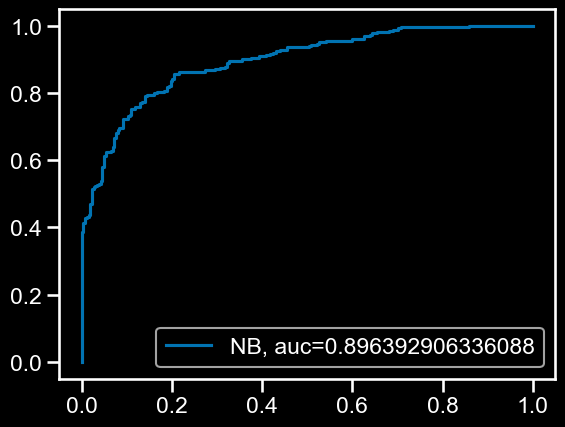

In [216]:
y_pred_proba = NB_clf.predict_proba(X_test)[::,1]
y_test = y_test.map({'spam': 1, 'ham': 0}).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr, label="NB, auc="+str(auc))

plt.legend(loc=4)
plt.show()


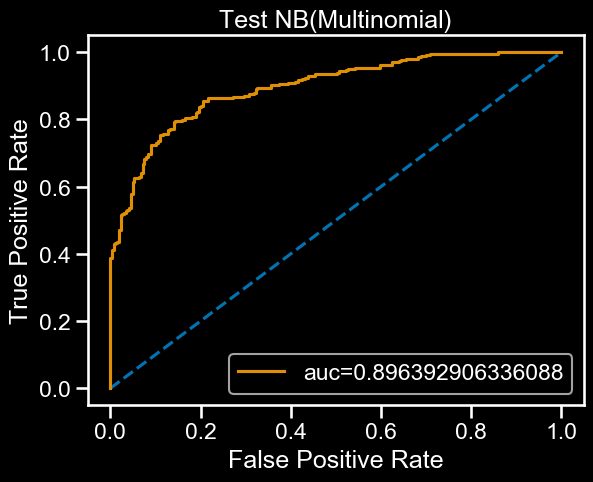

In [217]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = NB_clf.predict_proba(X_test)[::,1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.title("Test NB(Multinomial)")
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr, lr_tpr,label="auc="+str(auc))

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

### Pickle model ###

In [218]:
import pickle

NB_clf = make_pipeline(
    CountVectorizer(preprocessor=dummy, tokenizer=dummy, lowercase=False, ngram_range = (1, 2)),
    TfidfTransformer(norm='l2'),
    StandardScaler(with_mean=False),
    MaxAbsScaler(),
    MultinomialNB(alpha=1e-01, class_prior = [.2, .8])
)

%time NB_clf.fit(X_train, y_train)

with open('pkl/NB.pkl', 'wb') as file:
    pickle.dump(NB_clf, file)

CPU times: user 370 ms, sys: 64.7 ms, total: 435 ms
Wall time: 151 ms
